In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

%matplotlib inline
pd.options.display.max_columns = 50
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 경고창 무시
warnings.filterwarnings(action="ignore")

# 데이터 요약
1. OBS : Observation(ID)
2. CHK_ACCT (Checking account status) 
        0 : < 0 DM 
        1:  0 < ...< 200
        2 : => 200 DM 
        3:  no checking account 
3. DURATION (Duration of credit in months)
4. HISTORY (Credit history) 
        0: no credits taken
        1: all credits at this bank paid back duly  
        2: existing credits paid back duly till now  
        3: delay in paying off in the past   
        4: critical account   
5. NEW_CAR (Purpose of credit (new car))
6. USED_CAR (Purpose of credit (used car))
7. FURNITURE (Purpose of credit (furniture/equipment))
8. RADIO/TV (Purpose of credit (radio/television)) 
9. EDUCATION (Purpose of credit (education))   
10. RETRAINING (Purpose of credit (retraining))   
11. AMOUNT (Credit amount)
12. SAV_ACCT (Average balance in savings account) 
        0 : <  100 
        1 : 100<= ... <  500 
        2 : 500<= ... < 1000 
        3 : =>1000  
        4 : unknown/ no savings account 
13. EMPLOYMENT (Present employment since) 
        0 : unemployed 
        1:  < 1 year 
        2 : 1 <= ... < 4 years   
        3 : 4 <=... < 7 years 
        4 : >= 7 years 
        
14. INSTALL_RATE (Installment rate as % of disposable income)
15. MALE_DIV (Applicant is male and divorced) 
16. MALE_SINGLE (Applicant is male and single)
17. MALE_MAR_WID (Applicant is male and married or a widower)
18. CO-APPLICANT (Application has a co-applicant) 
19. GUARANTOR (Applicant has a guarantor)=
20. PRESENT_RESIDENT (Present resident since - years) 
        0 : <= 1 year 
        1 : < … <= 2 years 
        2 : < … <= 3 years 
        3 : > 4years 
21. REAL_ESTATE (Applicant owns real estate)
22. PROP_UNKN_NONE (Applicant owns no property)
23. AGE (Age in years)
24. OTHER_INSTALL (Applicant has other installment plan credit)
25. RENT (Applicant rents)
26. OWN_RES (Applicant owns residence) 
27. NUM_CREDITS (Number of existing credits at this bank)
28. JOB (Nature of job) 
        0 : unemployed/ unskilled  - non-resident
        1 : unskilled - resident 
        2 : skilled employee / official 
        3 : management/ self-employed/highly qualified employee/ officer 
29. NUM_DEPENDENTS (Number of people for whom liable to provide maintenance)
30. TELEPHONE (Applicant has phone in his or her name)
31. FOREIGNER (Foreign worker)
32. RESPONSE (Credit rating is good)

In [35]:
# 원본 데이터 불러오기
credit_df = pd.read_csv("credit_data.csv")

In [36]:
# 데이터 확인
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBS               1000 non-null   int64  
 1   CHK_ACCT          1000 non-null   int64  
 2   DURATION          1000 non-null   int64  
 3   HISTORY           1000 non-null   int64  
 4   NEW_CAR           1000 non-null   int64  
 5   USED_CAR          1000 non-null   int64  
 6   FURNITURE         1000 non-null   int64  
 7   RADIO/TV          1000 non-null   int64  
 8   EDUCATION         1000 non-null   int64  
 9   RETRAINING        1000 non-null   int64  
 10  AMOUNT            1000 non-null   int64  
 11  SAV_ACCT          1000 non-null   int64  
 12  EMPLOYMENT        996 non-null    float64
 13  INSTALL_RATE      1000 non-null   int64  
 14  MALE_DIV          1000 non-null   int64  
 15  MALE_SINGLE       1000 non-null   int64  
 16  MALE_MAR_or_WID   1000 non-null   int64  
 

# 데이터 전처리

In [37]:
# 당좌예금계좌 : 범주형 변수 처리
# 3: 당좌계좌 존재 X
# 당좌계좌 유무를 새로운 변수로 만듦
# 당좌계좌가 존재하지 않는 사람들은 계좌 잔액이 0이므로 0으로 처리 

credit_df['IS_CHK_ACCT'] = np.where(credit_df['CHK_ACCT'] == 3, 1, 0)
credit_df.loc[credit_df['CHK_ACCT'] == 3, 'CHK_ACCT'] = 0

In [38]:
# HISTORY: one_hot_encoding
one_hot = OneHotEncoder(sparse=False)
history_df = pd.DataFrame(one_hot.fit_transform(credit_df[['HISTORY']]))
history_df.columns = ['NO_CREDIT_HISTORY', 'DULY_PAY_HISTORY', 'NOW_PAY_HISTORY', 'DELAY_PAY_HISTORY', 'CRITICAL_ACCT']

# concat df
credit_df = pd.concat([credit_df, history_df], axis=1)
#credit_df['IS_CRITICAL'] = np.where(credit_df['HISTORY'] == 4, 1, 0)

In [39]:
# PURPOSE: '자산 목적', '교육 목적'
credit_df['ASSET_PURPOSE'] = np.where(credit_df['NEW_CAR'] == 1, 1,
                             np.where(credit_df['USED_CAR'] == 1, 1,
                                 np.where(credit_df['FURNITURE'] == 1, 1,
                                     np.where(credit_df['RADIO/TV'] == 1, 1, 0))))

credit_df.loc[credit_df['RETRAINING'] == 1,'EDUCATION'] = 1
credit_df = credit_df.rename(columns={'EDUCATION' : 'EDUCATION_PURPOSE'})

In [40]:
# 당좌예금(CHK_ACCT)과 똑같이 처리

credit_df['IS_SAV_ACCT'] = np.where(credit_df['SAV_ACCT'] == 4, 1, 0)
credit_df.loc[credit_df['SAV_ACCT'] == 4, 'SAV_ACCT'] = 0

In [41]:
# 성별: 남자와 여자로 나누기
credit_df['IS_MALE'] = np.where(credit_df['MALE_DIV'] == 1, 1,
                             np.where(credit_df['MALE_SINGLE'] == 1, 1,
                                 np.where(credit_df['MALE_MAR_or_WID'] == 1, 1, 0)))

credit_df = credit_df.drop(columns=['MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID'])

In [42]:
# 직업 유무로 나누기
credit_df['IS_JOB'] = np.where(credit_df['JOB'] == 0, 0, 1)

#### 결측치 처리

In [43]:
# 결측치 안에서 특별한 패턴을 찾을 수 없었으며
# 전체 데이터의 0.8% 밖에 되지 않아, 삭제하더라도 모델의 결과에 영향을 끼치지 않을 것이라고 판단
credit_df = credit_df.dropna()

# EDA

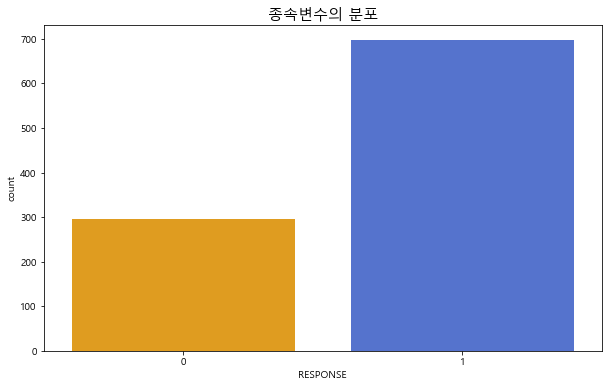

In [44]:
# 종속 변수의 비율이 약 2.3배 -> SMOTE 사용하여 balancing
plt.figure(figsize=(10, 6))
plt.title("종속변수의 분포", fontsize=15)
sns.countplot(credit_df['RESPONSE'], palette=['orange', 'royalblue'])
plt.show()

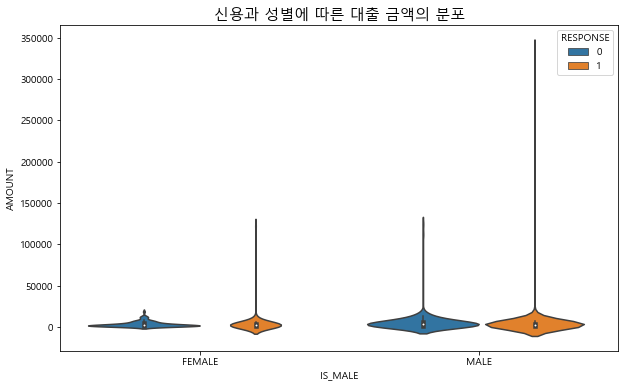

In [58]:
# 대출액이 150000이 넘어가는 사람들은 모두 남성이며, 모두 신용 좋음
# 여성 중 대출액이 50000 보다 작은 사람은 모두 신용이 안좋음
plt.figure(figsize=(10, 6))
plt.title("신용과 성별에 따른 대출 금액의 분포", fontsize=15)
sns.violinplot(credit_df['IS_MALE'], credit_df['AMOUNT'], hue=credit_df['RESPONSE'])
plt.xticks([0, 1], ["FEMALE", "MALE"])
plt.show()

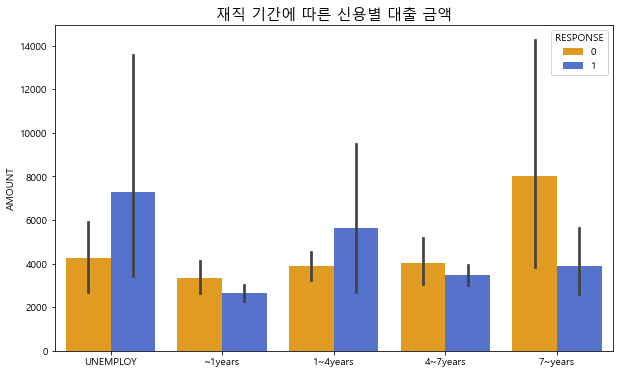

In [68]:
# 재직기간이 7년 이상인 사람들 중 대출 금액이 큰 사람들은 신용이 낮은 경향
# 대출금액이 10000 이상이며 재직기간이 7년 이상인 사람들은 신용이 낮은 경향이 있으며,
# 대출금액이 10000 이상이지만 무직인 사람들은 신용이 높은 경향이 있다/
plt.figure(figsize=(10, 6))
plt.title("재직 기간에 따른 신용별 대출 금액", fontsize=15)
sns.barplot(credit_df['EMPLOYMENT'], credit_df['AMOUNT'], hue=credit_df['RESPONSE'], palette=['orange', 'royalblue'])
plt.xticks([0, 1, 2, 3, 4], ["UNEMPLOY", "~1years", "1~4years", "4~7years", "7~years"])
plt.xlabel(None)
plt.show()

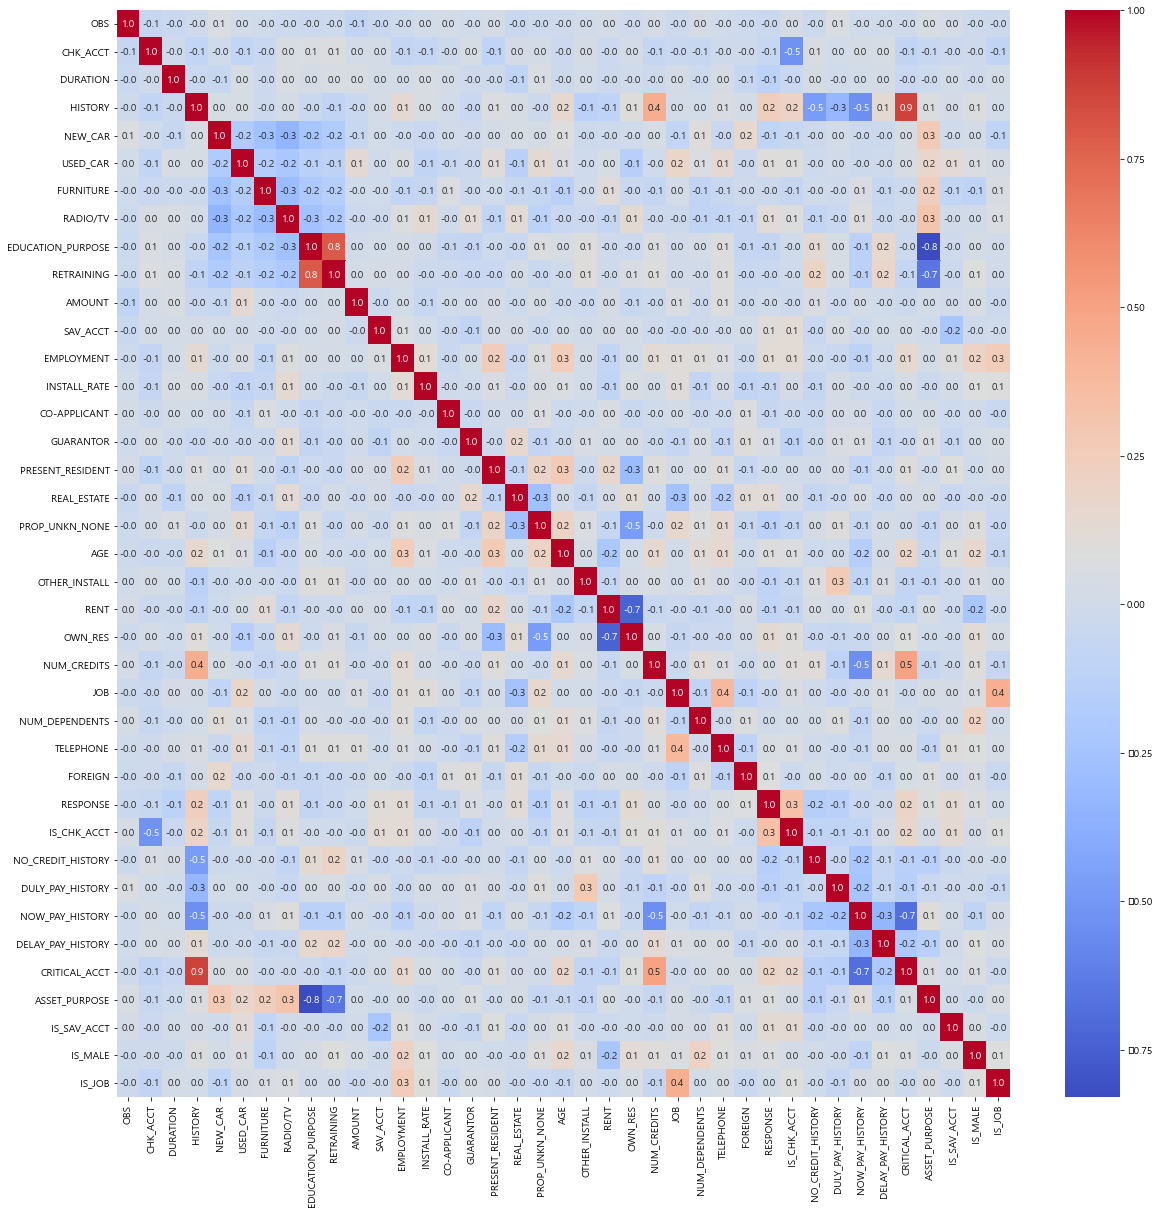

In [75]:
plt.figure(figsize=(20,20))
sns.heatmap(credit_df.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.show()